In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif,f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
import optuna
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import learning_curve
# Load data
hh = pd.read_csv("file.csv")

print(hh.head())
print(hh.info())


In [2]:
#sns.pairplot(hh,hue="vulnerability_flag")

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(hh.isna(),cbar=False)

In [ ]:
print(hh["columns"].value_counts(normalize=True))

In [7]:
hh.dtypes
hh.set_index(["household_id"], inplace=True)

In [9]:
hh.drop_duplicates(inplace=True)

In [ ]:
toLabel=hh.select_dtypes(include="object").columns.tolist()
toLabel

In [11]:
encoder=OrdinalEncoder()
hh[toLabel]=encoder.fit_transform(hh[toLabel])

In [ ]:
plt.figure(figsize=(25,12))
sns.heatmap(hh.corr(method="spearman"),cbar=True,annot=True)
plt.show()

In [ ]:
Target="TargetColumn"
plt.figure(figsize=(4,12))
sns.heatmap(hh.corr(method="spearman")[[Target]].sort_values(by=Target,ascending=False),cbar=True,annot=True)
plt.show()

In [ ]:
print(hh.isna().sum())

In [10]:
hh.describe()

,household_id,governorate,area_type,num_members,num_children,num_elderly,num_working_age,head_age,head_gender,head_education,...,assistance_last_6m,dependency_ratio,consumption_per_capita,rent_share,food_share,debt_to_income,poverty_line,extreme_poor,pmt_score,vulnerability_flag
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1120.000000,...,1500.000000,1500.000000,1.500000e+03,1500.000000,1500.000000,1500.000000,1.500000e+03,1500.000000,1500.000000,1500.000000
mean,750.500000,2.313333,1.341333,6.557333,2.942667,0.526667,3.168000,46.734000,0.701333,1.302679,...,0.482000,0.525237,1.570773e+06,0.365254,0.408191,0.999307,7.820333e+06,0.113333,0.447965,0.116000
std,433.157015,1.640208,0.786493,2.860565,1.802280,0.698771,1.781168,15.963034,0.457826,1.150200,...,0.499843,0.244923,1.178191e+06,0.175880,0.092627,1.302749,7.678626e+05,0.317106,0.119583,0.320332
min,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,...,0.000000,0.000000,2.830000e+05,0.023000,0.116000,0.030000,7.000000e+06,0.000000,0.000000,0.000000
25%,375.750000,1.000000,1.000000,4.000000,2.000000,0.000000,2.000000,33.000000,0.000000,0.000000,...,0.000000,0.375000,7.910000e+05,0.223750,0.351000,0.310000,7.000000e+06,0.000000,0.370300,0.000000
50%,750.500000,2.000000,2.000000,7.000000,3.000000,0.000000,3.000000,47.000000,1.000000,1.000000,...,0.000000,0.500000,1.172000e+06,0.360000,0.409000,0.600000,7.500000e+06,0.000000,0.447600,0.000000
75%,1125.250000,4.000000,2.000000,9.000000,4.000000,1.000000,4.000000,61.000000,1.000000,2.000000,...,1.000000,0.666667,1.933000e+06,0.507000,0.475000,1.220000,8.500000e+06,0.000000,0.524225,0.000000
max,1500.000000,5.000000,2.000000,11.000000,10.000000,3.000000,10.000000,74.000000,1.000000,3.000000,...,1.000000,1.500000,1.000000e+07,0.852000,0.600000,18.670000,9.000000e+06,1.000000,1.000000,1.000000


vulnerability_flag
0    0.884
1    0.116
Name: proportion, dtype: float64

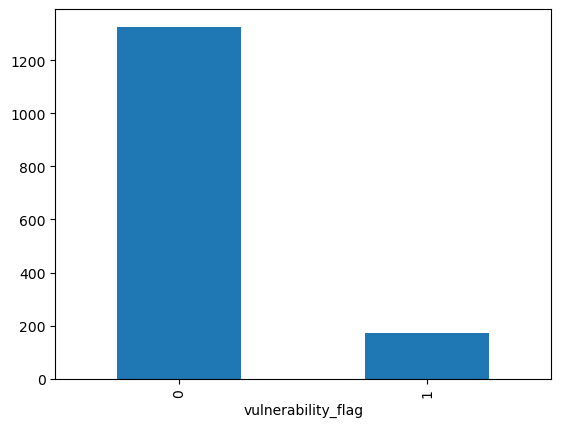

In [ ]:
hh[Target].value_counts().plot.bar()
hh[Target].value_counts(normalize=True)

In [14]:
hh.drop(columns=["education_expenditure","head_education"],inplace=True)


In [15]:
hh["debt_amount"]=hh["debt_amount"].fillna(0.0)
hh["legal_residency_rate"]=hh["legal_residency_rate"].fillna(hh["legal_residency_rate"].median())

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(hh.isna(),cbar=False)

In [35]:
xcolumns=[c for c in hh.columns if c not in ["vulnerability_flag","household_id","pmt_score"]]
X=hh[xcolumns]
y=hh["vulnerability_flag"]
yreg=hh["pmt_score"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

X_trainreg, X_testreg, y_trainreg, y_testreg = train_test_split(
    X, yreg, test_size=0.25, random_state=0)



In [17]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X,y= ros.fit_resample(X,y)


In [ ]:
def objective(trial):
    k = trial.suggest_int("k", 5, X.shape[1])
    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', [ 'RandomForest', 'LinearRegression'])
    if classifier_name=='LinearRegression':   
        classifier_obj = sklearn.linear_model.LinearRegression()
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestRegressor(max_depth=rf_max_depth)

    model=Pipeline([
        ("Select",SelectKBest(f_regression,k=k)),
        ("clf",classifier_obj)])

    skf = KFold(n_splits=5)    
    accuracy= cross_val_score(model,X,yreg,cv=skf).mean()
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [ ]:
def objective(trial):
    k = trial.suggest_int("k", 5, X.shape[1])
    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest', 'LogisticRegression'])
    if classifier_name == 'SVC':
         svc_c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
         classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')
    elif classifier_name=='LogisticRegression':
        C = trial.suggest_float('C', 1e-5, 1e2, log=True)    
        penalty =  trial.suggest_categorical('penalty',['l1', 'l2'])
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga']) 
        classifier_obj = sklearn.linear_model.LogisticRegression(C=C,penalty=penalty,solver=solver)
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    model=Pipeline([
        ("Select",SelectKBest(f_classif,k=k)),
        ("clf",classifier_obj)])

    skf = StratifiedKFold(n_splits=5)    
    accuracy= cross_val_score(model,X,yreg,cv=skf).mean()
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
best_params = study.best_params
print(best_params)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,explained_variance_score
final_model = Pipeline([
    ("select", SelectKBest(f_classif, k=29)),
    ("clf", LinearRegression())
])

final_model.fit(X_trainreg, y_trainreg)
pred=final_model.predict(X_testreg)
#pred_proba = final_model.predict_proba(X_test)[:, 1]
rmse = mean_squared_error(y_testreg, pred)
r2 = r2_score(y_testreg, pred, multioutput='variance_weighted')
mae=mean_absolute_error(y_testreg, pred, multioutput='raw_values')
explained_variance_score=explained_variance_score(y_testreg, pred)
print("RMSE:", rmse)
print("R^2:", r2)
print("mean_absolute_error:", mae)
print("explained_variance_score:", explained_variance_score)
# accuracy = accuracy_score(y_testreg, pred)
# precision = precision_score(y_testreg, pred)
# recall = recall_score(y_testreg, pred)
# f1 = f1_score(y_testreg, pred)
# # auc = roc_auc_score(y_testreg, pred_proba)

# print("Accuracy:", accuracy)
# print("Precision:", precision, )
# print("Recall:", recall)
# print("F1-score:", f1)
# #print("AUC:", auc)


# Accuracy: 0.9173
# Precision: 0.7857
# Recall: 0.2821
# F1-score: 0.4151
# AUC: 0.7556

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42
)

rf.fit(X_trainreg, y_trainreg)
y_pred = rf.predict(X_testreg)

print("RMSE:", mean_squared_error(y_testreg, y_pred))
print("R^2:", r2_score(y_testreg, y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression

# 1. Create the model
model = Pipeline([
    ("select", SelectKBest(f_classif, k=10)),
    ("clf", LogisticRegression())
])


# 2. Fit the model
model.fit(X_train, y_train)

# 3. Predict
y_pred = model.predict(X_test)

# 4. Accuracy (optional)
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
ConfusionMatrixDisplay.from_estimator(final_model, X, y)
plt.show()

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
        final_model, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10) # Varying training set sizes
    )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)




plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="red", marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="red")

plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import DetCurveDisplay
classifiers = {

    "final": final_model,
    "Random Forest": RandomForestClassifier(max_depth=5, random_state=42)
}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(10, 4))
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import LearningCurveDisplay



tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, max_depth=3, tol=1e-3)

train_sizes = np.linspace(0.4, 1.0, 10)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
LearningCurveDisplay.from_estimator(final_model, X, y,
                                
                                    ax=axes[0],
                                    scoring='accuracy')
axes[0].set_title('Final')
LearningCurveDisplay.from_estimator(gb_clf, X, y,
                                  
                                    ax=axes[1],
                                    scoring='accuracy')
axes[1].set_title('GradientBoostingClassifier')
plt.show()

In [ ]:
import joblib
save_path =  f"PredictVul.joblib"

joblib.dump(final_model, save_path)
print(f"\n✅ Fitted model saved to: {save_path}")